In [1]:
import numpy as np
import torch
import torch.nn as nn
from dct_model import DCTLinearFactored

input_size = 28

standard = nn.Linear(input_size * input_size, 1)
dct_factored = DCTLinearFactored(input_size)

print(f"Standard Linear: {sum(p.numel() for p in standard.parameters())} params")
print(f"DCT Factored: {sum(p.numel() for p in dct_factored.parameters())} params")
print(f"Reduction: {sum(p.numel() for p in dct_factored.parameters()) / sum(p.numel() for p in standard.parameters()) * 100:.1f}%")

x = torch.randn(4, input_size * input_size)
out_standard = standard(x)
out_dct = dct_factored(x)

print(f"\nOutput shapes: {out_standard.shape}, {out_dct.shape}")
print(f"\nWeight matrix rank: 1 (factored as outer product)")

Standard Linear: 785 params
DCT Factored: 57 params
Reduction: 7.3%

Output shapes: torch.Size([4, 1]), torch.Size([4, 1])

Weight matrix rank: 1 (factored as outer product)


In [2]:
# Load and prepare the Breast Cancer Wisconsin dataset
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load dataset
data = load_breast_cancer()
X = data.data
y = data.target

print(f"\nDataset shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")

# Pad features to 36 (6x6) for 2D representation
import math
n_features = X.shape[1]
grid_size = int(math.ceil(math.sqrt(n_features)))
n_padded = grid_size ** 2

print(f"Padding from {n_features} to {n_padded} features ({grid_size}x{grid_size})")

X_padded = np.zeros((X.shape[0], n_padded))
X_padded[:, :n_features] = X

print(f"Target distribution: {np.bincount(y)}")
print("0: Malignant, 1: Benign")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

print(f"\nTraining set: {X_train_tensor.shape}")
print(f"Test set: {X_test_tensor.shape}")
print(f"Grid size for 2D DCT: {grid_size}x{grid_size}")

Using device: cuda

Dataset shape: (569, 30)
Number of features: 30
Padding from 30 to 36 features (6x6)
Target distribution: [212 357]
0: Malignant, 1: Benign

Training set: torch.Size([455, 36])
Test set: torch.Size([114, 36])
Grid size for 2D DCT: 6x6


In [3]:
# Experiment with different training data scales
data_scales = [5, 10, 20, 30, 50, 100, 200, 300]
results = []

input_features = X_train_tensor.shape[1]
input_grid_size = int(math.sqrt(input_features))

print(f"Input grid size: {input_grid_size}x{input_grid_size} = {input_features} features")
print(f"Total training samples available: {len(X_train_tensor)}")
print(f"\nTesting with sample sizes: {data_scales}")
print("=" * 70)

Input grid size: 6x6 = 36 features
Total training samples available: 455

Testing with sample sizes: [5, 10, 20, 30, 50, 100, 200, 300]


In [4]:
# Train and evaluate models for each data scale
from torch.utils.data import TensorDataset, DataLoader

criterion = nn.BCELoss()
batch_size = 32
num_epochs = 1000

for n_samples in data_scales:
    print(f"\n{'='*70}")
    print(f"Training with {n_samples} samples")
    print(f"{'='*70}")
    
    # Subset the training data
    X_train_subset = X_train_tensor[:n_samples]
    y_train_subset = y_train_tensor[:n_samples]
    
    # Create fresh models for each scale
    standard_model = nn.Sequential(
        nn.Linear(input_features, 1),
        nn.Sigmoid()
    ).to(device)
    
    dct_model = DCTLinearFactored(input_grid_size).to(device)
    
    # Create data loader
    train_dataset = TensorDataset(X_train_subset, y_train_subset)
    train_loader = DataLoader(train_dataset, batch_size=min(batch_size, n_samples), shuffle=True)
    
    # Train Standard Linear model
    optimizer_standard = torch.optim.Adam(standard_model.parameters(), lr=0.01)
    print("\nTraining Standard Linear Model...")
    for epoch in range(num_epochs):
        standard_model.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            outputs = standard_model(batch_X).squeeze()
            loss = criterion(outputs, batch_y)
            
            optimizer_standard.zero_grad()
            loss.backward()
            optimizer_standard.step()
            
            epoch_loss += loss.item()
        
        if (epoch + 1) % 200 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}')
    
    # Train DCT Factored model
    optimizer_dct = torch.optim.Adam(dct_model.parameters(), lr=0.01)
    print("\nTraining DCT Factored Model...")
    for epoch in range(num_epochs):
        dct_model.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            outputs = dct_model(batch_X).squeeze()
            loss = criterion(outputs, batch_y)
            
            optimizer_dct.zero_grad()
            loss.backward()
            optimizer_dct.step()
            
            epoch_loss += loss.item()
        
        if (epoch + 1) % 200 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}')
    
    # Evaluate both models
    standard_model.eval()
    dct_model.eval()
    
    with torch.no_grad():
        # Standard model predictions
        y_pred_standard_train = (standard_model(X_train_subset).squeeze() > 0.5).float().cpu().numpy()
        y_pred_standard_test = (standard_model(X_test_tensor).squeeze() > 0.5).float().cpu().numpy()
        
        # DCT model predictions
        y_pred_dct_train = (dct_model(X_train_subset).squeeze() > 0.5).float().cpu().numpy()
        y_pred_dct_test = (dct_model(X_test_tensor).squeeze() > 0.5).float().cpu().numpy()
    
    # Calculate accuracies
    standard_train_acc = accuracy_score(y_train_subset.cpu().numpy(), y_pred_standard_train)
    standard_test_acc = accuracy_score(y_test, y_pred_standard_test)
    dct_train_acc = accuracy_score(y_train_subset.cpu().numpy(), y_pred_dct_train)
    dct_test_acc = accuracy_score(y_test, y_pred_dct_test)
    
    # Store results
    results.append({
        'n_samples': n_samples,
        'standard_train_acc': standard_train_acc,
        'standard_test_acc': standard_test_acc,
        'dct_train_acc': dct_train_acc,
        'dct_test_acc': dct_test_acc
    })
    
    print(f"\n{'='*70}")
    print(f"Results for {n_samples} samples:")
    print(f"{'='*70}")
    print(f"Standard Linear - Train: {standard_train_acc:.4f}, Test: {standard_test_acc:.4f}")
    print(f"DCT Factored    - Train: {dct_train_acc:.4f}, Test: {dct_test_acc:.4f}")

print(f"\n{'='*70}")
print("All experiments completed!")
print(f"{'='*70}")


Training with 5 samples

Training Standard Linear Model...

Training Standard Linear Model...
Epoch [200/1000], Loss: 0.0050
Epoch [400/1000], Loss: 0.0019
Epoch [200/1000], Loss: 0.0050
Epoch [400/1000], Loss: 0.0019
Epoch [600/1000], Loss: 0.0010
Epoch [800/1000], Loss: 0.0007
Epoch [600/1000], Loss: 0.0010
Epoch [800/1000], Loss: 0.0007
Epoch [1000/1000], Loss: 0.0005

Training DCT Factored Model...
Epoch [1000/1000], Loss: 0.0005

Training DCT Factored Model...
Epoch [200/1000], Loss: 0.0065
Epoch [200/1000], Loss: 0.0065
Epoch [400/1000], Loss: 0.0021
Epoch [400/1000], Loss: 0.0021
Epoch [600/1000], Loss: 0.0011
Epoch [600/1000], Loss: 0.0011
Epoch [800/1000], Loss: 0.0006
Epoch [800/1000], Loss: 0.0006
Epoch [1000/1000], Loss: 0.0004

Results for 5 samples:
Standard Linear - Train: 1.0000, Test: 0.8860
DCT Factored    - Train: 1.0000, Test: 0.8070

Training with 10 samples

Training Standard Linear Model...
Epoch [200/1000], Loss: 0.0107
Epoch [1000/1000], Loss: 0.0004

Results 

In [5]:
# Convert results to DataFrame for easy viewing
results_df = pd.DataFrame(results)
print("\n" + "="*70)
print("SUMMARY OF ALL EXPERIMENTS")
print("="*70)
print(results_df.to_string(index=False))

# Calculate average differences
results_df['standard_gap'] = results_df['standard_train_acc'] - results_df['standard_test_acc']
results_df['dct_gap'] = results_df['dct_train_acc'] - results_df['dct_test_acc']
results_df['test_diff'] = results_df['standard_test_acc'] - results_df['dct_test_acc']

print("\n" + "="*70)
print("ANALYSIS")
print("="*70)
print(f"Average test accuracy - Standard: {results_df['standard_test_acc'].mean():.4f}")
print(f"Average test accuracy - DCT: {results_df['dct_test_acc'].mean():.4f}")
print(f"Average train-test gap - Standard: {results_df['standard_gap'].mean():.4f}")
print(f"Average train-test gap - DCT: {results_df['dct_gap'].mean():.4f}")


SUMMARY OF ALL EXPERIMENTS
 n_samples  standard_train_acc  standard_test_acc  dct_train_acc  dct_test_acc
         5            1.000000           0.885965       1.000000      0.807018
        10            1.000000           0.912281       1.000000      0.798246
        20            1.000000           0.912281       1.000000      0.868421
        30            1.000000           0.859649       1.000000      0.912281
        50            1.000000           0.903509       1.000000      0.912281
       100            1.000000           0.947368       0.990000      0.912281
       200            1.000000           0.956140       0.990000      0.929825
       300            0.993333           0.973684       0.976667      0.921053

ANALYSIS
Average test accuracy - Standard: 0.9189
Average test accuracy - DCT: 0.8827
Average train-test gap - Standard: 0.0803
Average train-test gap - DCT: 0.1119


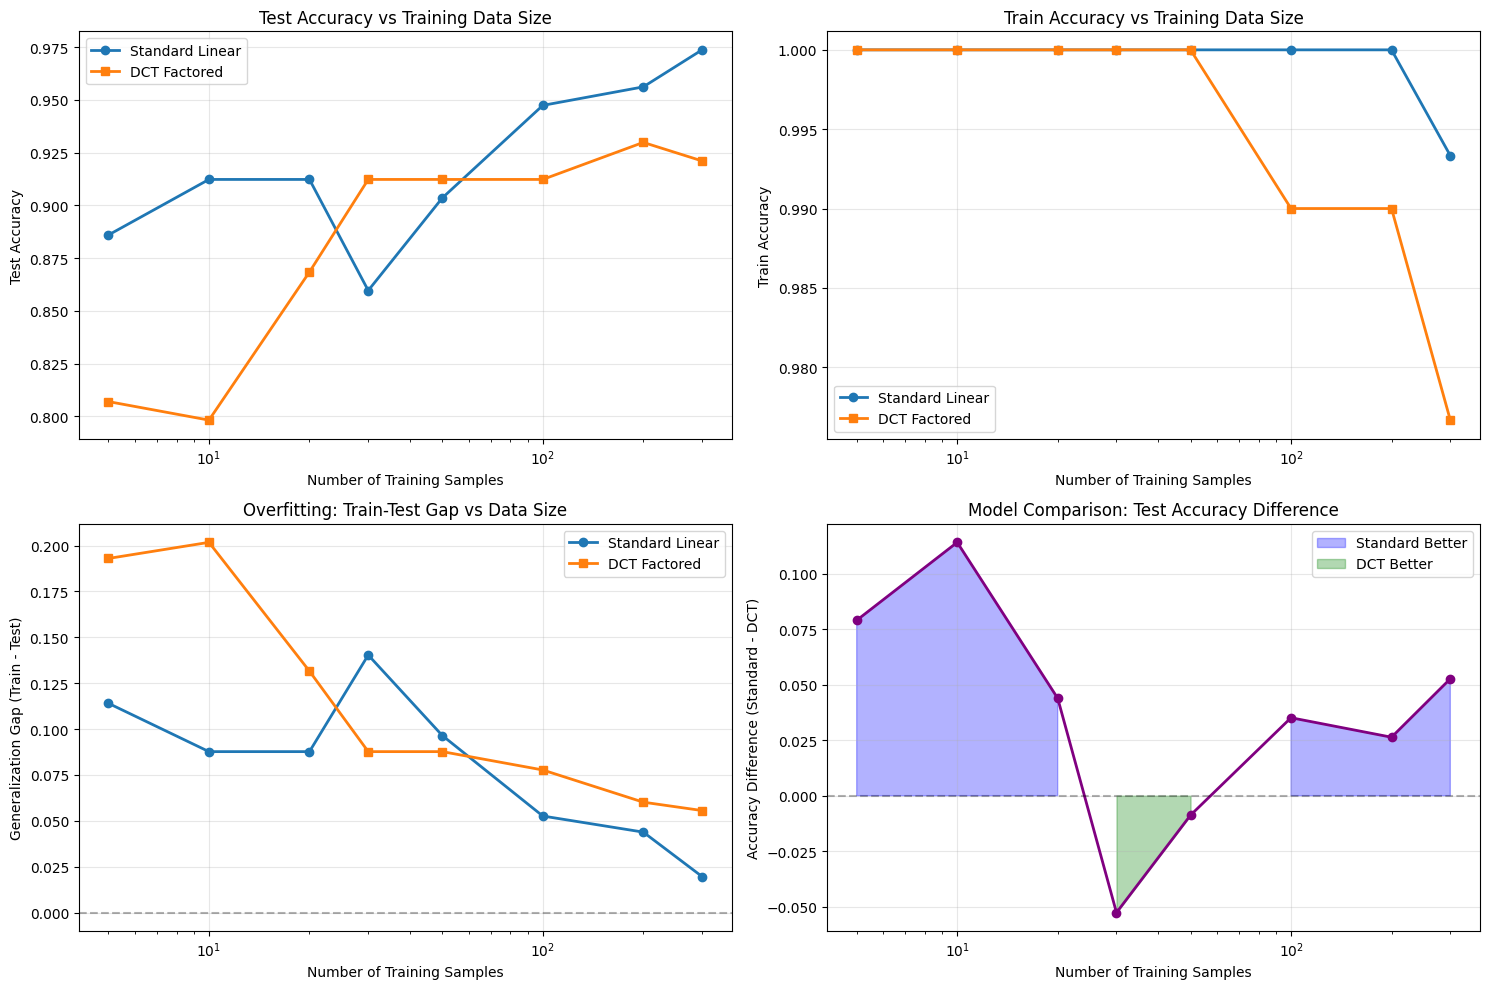

In [6]:
# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Test Accuracy vs Sample Size
axes[0, 0].plot(results_df['n_samples'], results_df['standard_test_acc'], 
                marker='o', label='Standard Linear', linewidth=2)
axes[0, 0].plot(results_df['n_samples'], results_df['dct_test_acc'], 
                marker='s', label='DCT Factored', linewidth=2)
axes[0, 0].set_xlabel('Number of Training Samples')
axes[0, 0].set_ylabel('Test Accuracy')
axes[0, 0].set_title('Test Accuracy vs Training Data Size')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xscale('log')

# Plot 2: Train Accuracy vs Sample Size
axes[0, 1].plot(results_df['n_samples'], results_df['standard_train_acc'], 
                marker='o', label='Standard Linear', linewidth=2)
axes[0, 1].plot(results_df['n_samples'], results_df['dct_train_acc'], 
                marker='s', label='DCT Factored', linewidth=2)
axes[0, 1].set_xlabel('Number of Training Samples')
axes[0, 1].set_ylabel('Train Accuracy')
axes[0, 1].set_title('Train Accuracy vs Training Data Size')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xscale('log')

# Plot 3: Generalization Gap (Train - Test)
axes[1, 0].plot(results_df['n_samples'], results_df['standard_gap'], 
                marker='o', label='Standard Linear', linewidth=2)
axes[1, 0].plot(results_df['n_samples'], results_df['dct_gap'], 
                marker='s', label='DCT Factored', linewidth=2)
axes[1, 0].set_xlabel('Number of Training Samples')
axes[1, 0].set_ylabel('Generalization Gap (Train - Test)')
axes[1, 0].set_title('Overfitting: Train-Test Gap vs Data Size')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xscale('log')
axes[1, 0].axhline(y=0, color='k', linestyle='--', alpha=0.3)

# Plot 4: Performance Difference (Standard - DCT on Test)
axes[1, 1].plot(results_df['n_samples'], results_df['test_diff'], 
                marker='o', linewidth=2, color='purple')
axes[1, 1].set_xlabel('Number of Training Samples')
axes[1, 1].set_ylabel('Accuracy Difference (Standard - DCT)')
axes[1, 1].set_title('Model Comparison: Test Accuracy Difference')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xscale('log')
axes[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[1, 1].fill_between(results_df['n_samples'], 0, results_df['test_diff'], 
                         where=(results_df['test_diff'] >= 0), alpha=0.3, 
                         color='blue', label='Standard Better')
axes[1, 1].fill_between(results_df['n_samples'], 0, results_df['test_diff'], 
                         where=(results_df['test_diff'] < 0), alpha=0.3, 
                         color='green', label='DCT Better')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

In [7]:
# Show detailed table with formatting
print("\n" + "="*90)
print("DETAILED RESULTS TABLE")
print("="*90)
print(f"{'Samples':>8} {'Std Train':>10} {'Std Test':>10} {'DCT Train':>10} {'DCT Test':>10} {'Difference':>12}")
print("-"*90)
for _, row in results_df.iterrows():
    print(f"{row['n_samples']:>8.0f} "
          f"{row['standard_train_acc']:>10.4f} "
          f"{row['standard_test_acc']:>10.4f} "
          f"{row['dct_train_acc']:>10.4f} "
          f"{row['dct_test_acc']:>10.4f} "
          f"{row['test_diff']:>12.4f}")
print("="*90)

# Key insights
print("\nKEY INSIGHTS:")
print(f"1. Parameter reduction: {sum(p.numel() for p in dct_model.parameters())} vs "
      f"{sum(p.numel() for p in standard_model.parameters())} "
      f"({sum(p.numel() for p in dct_model.parameters()) / sum(p.numel() for p in standard_model.parameters()) * 100:.1f}%)")

best_dct_idx = results_df['dct_test_acc'].idxmax()
best_std_idx = results_df['standard_test_acc'].idxmax()
print(f"2. Best DCT test accuracy: {results_df.loc[best_dct_idx, 'dct_test_acc']:.4f} "
      f"at {results_df.loc[best_dct_idx, 'n_samples']:.0f} samples")
print(f"3. Best Standard test accuracy: {results_df.loc[best_std_idx, 'standard_test_acc']:.4f} "
      f"at {results_df.loc[best_std_idx, 'n_samples']:.0f} samples")

# Count wins
dct_wins = (results_df['dct_test_acc'] > results_df['standard_test_acc']).sum()
std_wins = (results_df['standard_test_acc'] > results_df['dct_test_acc']).sum()
print(f"4. DCT wins on test set: {dct_wins}/{len(results_df)} cases")
print(f"5. Standard wins on test set: {std_wins}/{len(results_df)} cases")


DETAILED RESULTS TABLE
 Samples  Std Train   Std Test  DCT Train   DCT Test   Difference
------------------------------------------------------------------------------------------
       5     1.0000     0.8860     1.0000     0.8070       0.0789
      10     1.0000     0.9123     1.0000     0.7982       0.1140
      20     1.0000     0.9123     1.0000     0.8684       0.0439
      30     1.0000     0.8596     1.0000     0.9123      -0.0526
      50     1.0000     0.9035     1.0000     0.9123      -0.0088
     100     1.0000     0.9474     0.9900     0.9123       0.0351
     200     1.0000     0.9561     0.9900     0.9298       0.0263
     300     0.9933     0.9737     0.9767     0.9211       0.0526

KEY INSIGHTS:
1. Parameter reduction: 13 vs 37 (35.1%)
2. Best DCT test accuracy: 0.9298 at 200 samples
3. Best Standard test accuracy: 0.9737 at 300 samples
4. DCT wins on test set: 2/8 cases
5. Standard wins on test set: 6/8 cases
